In [ ]:
# https://www.youtube.com/watch?v=nuIqwnsrnH0
# https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L11/code/11-eval4-algo__nested-cv_verbose1.ipynb
# https://arxiv.org/abs/1811.12808
# https://www.youtube.com/watch?v=DuDtXtKNpZs

In [18]:
import sys
sys.path.append("/home/rafal/WORK/IMPAN/LocalRegression/")

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import sklearn
import scipy.stats as ss
from pyearth import Earth
import catboost as cb
from BMR.bmr import optimize_min_n_pts, BMR
from BMR.polynomial_regression import PolynomialRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml

In [43]:
housing = fetch_california_housing()
X = housing['data']
y = housing['target']
Xy = np.hstack([y.reshape(-1,1), X])

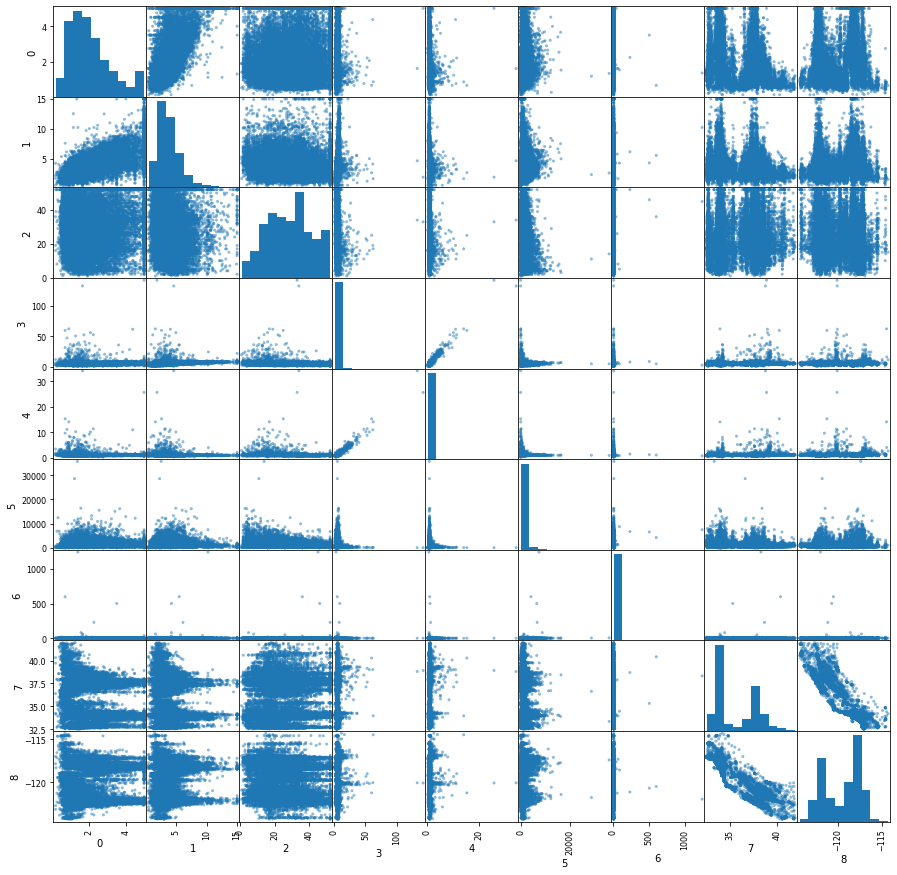

In [44]:
# first column is the target value
g = pd.plotting.scatter_matrix(pd.DataFrame(Xy), figsize=(15, 15))

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
# def plot_prediction(model, title, log=False, with_data=True):
#     points_per_axis = 25
#     my, mx = np.meshgrid(np.linspace(0, 1, points_per_axis), np.linspace(0, 1, points_per_axis))
#     mpos = np.vstack([my.ravel(), mx.ravel()]).T
#     z = model.predict(mpos).reshape(points_per_axis, points_per_axis)
#     z_him = Himmelblau(mpos).reshape(points_per_axis, points_per_axis)
#     if log:
#         z = np.log(z)
#         z_him = np.log(z_him)
#     fig, axs = plt.subplots(1,2, figsize=(10,4.5))
#     axs[0].contourf(mx, my, z_him, levels=20)
#     if with_data:
#         axs[0].plot(X_train_val[:, 0], X_train_val[:, 1], 'o', color='white', markersize=1)
#     axs[0].set_title('Himmelblau function')
#     axs[1].contourf(mx, my, z, levels=20)
#     axs[1].set_title(f'{title}')
#     plt.show()
    
def evaluate_estimator(pipe, param_grid, cv=5, n_jobs=None):
    gcv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)
    gcv.fit(X_train_val, y_train_val)
    pred = gcv.predict(X_test)
    r2 = r2_score(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    mse = mean_squared_error(pred, y_test)
    return gcv.best_estimator_, gcv.best_params_, r2, mae, mse, gcv

In [55]:
# Polynomial Regression
label='polynomialregression'
reg_poly = PolynomialRegression()
pipe_poly = Pipeline([('std', StandardScaler()), ('reg', reg_poly)])
param_grid_poly = [{'reg__degree': [1, 2, 3, 4, 5]}]

output_polynomial = evaluate_estimator(pipe_poly, param_grid_poly, cv=5, n_jobs=6)
print(output_polynomial[1])
print(f'R2: {output_polynomial[2]} MAE: {output_polynomial[3]} MSE: {output_polynomial[4]}')

{'reg__degree': 1}
R2: 0.37999448635001365 MAE: 0.5328685121247784 MSE: 0.5291402345397308


In [56]:
# SVR
label='SVR'
reg_svr = SVR()
pipe_svr = Pipeline([('std', StandardScaler()), ('reg', reg_svr)])
param_grid_svr = {'reg__degree': [1, 2, 3, 4],
                   'reg__C': [0.1, 1, 3, 5]}
output_svr = evaluate_estimator(pipe_svr, param_grid_svr, cv=5, n_jobs=6)

R2: 0.6616049466391871 MAE: 0.37858198129484993 MSE: 0.3305029090433146


In [57]:
print(output_svr[1])
print(f'R2: {output_svr[2]} MAE: {output_svr[3]} MSE: {output_svr[4]}')

{'reg__C': 5, 'reg__degree': 1}
R2: 0.6616049466391871 MAE: 0.37858198129484993 MSE: 0.3305029090433146


In [59]:
# MARS
label='MARS'
reg_mars = Earth()
pipe_mars = Pipeline([('std', StandardScaler()), ('reg', reg_mars)])
param_grid_mars = {'reg__max_terms': [None, 1, 2, 3, 4]}
output_mars = evaluate_estimator(pipe_mars, param_grid_mars, cv=5, n_jobs=6)
print(output_mars[1])
print(f'R2: {output_mars[2]} MAE: {output_mars[3]} MSE: {output_mars[4]}')

{'reg__max_terms': None}
R2: 0.5600953664919981 MAE: 0.46392064582668285 MSE: 0.41634799896868463


In [58]:
# RF
label='RF'
reg_rf = RandomForestRegressor()
pipe_rf = Pipeline([('std', StandardScaler()), ('reg', reg_rf)])
param_grid_rf = {'reg__n_estimators': [10, 100, 200, 500]}
output_rf = evaluate_estimator(pipe_rf, param_grid_rf, cv=5, n_jobs=5)
print(output_rf[1])
print(f'R2: {output_rf[2]} MAE: {output_rf[3]} MSE: {output_rf[4]}')

{'reg__n_estimators': 500}
R2: 0.7502302316653361 MAE: 0.3258372030329455 MSE: 0.2519730868828013


(array([1.9816e+04, 7.1100e+02, 9.5000e+01, 1.2000e+01, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-1.25612255,  1.89452273,  5.04516801,  8.19581328, 11.34645856,
        14.49710384, 17.64774911, 20.79839439, 23.94903967, 27.09968494,
        30.25033022]),
 <BarContainer object of 10 artists>)

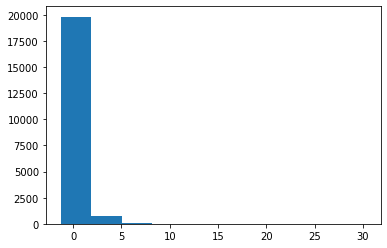

In [70]:
# Select reasonable values of parameters
# std = StandardScaler().fit_transform(X)
# plt.hist(std[:, 4])

In [72]:
# BMR
label='BMR'
reg_bmr = BMR(epsilon=0.1, min_n_pts=5, M=20)

pipe_bmr = Pipeline([('std', StandardScaler()), ('reg', reg_bmr)])
param_grid_bmr = {
    'reg__epsilon': [1.0],
    'reg__min_n_pt': [25]
}
output_bmr = evaluate_estimator(pipe_bmr, param_grid_bmr, cv=5, n_jobs=5)
print(output_bmr[1])
print(f'R2: {output_bmr[2]} MAE: {output_bmr[3]} MSE: {output_bmr[4]}')

{'reg__epsilon': 1.0, 'reg__min_n_pt': 25}
R2: 0.09523848631782172 MAE: 0.6496437605479466 MSE: 6.327444736343728


In [73]:
Xstd = StandardScaler().fit_transform(X_train_val)